In [ ]:
from astropy.table import Table
import galsim
import galcheat
import numpy as np
import matplotlib.pyplot as plt


# Galaxy density

In [ ]:
cat = Table.read('../OneDegSq.fits')


In [ ]:
# density in arcmin with i < 27 (target depth)
dens = len(cat[cat['i_ab'] < 27]) / (60 * 60)

dens_arcsec = dens / 3600

# corresponding to expected number of galaxies in 88x88 pixels with scale = 0.2 
exp = (dens / (60 * 60)) * 88 * 88 * 0.2 * 0.2

print(dens, exp )


159.97305555555556 13.764792691358025


In [ ]:
# snr of a star with median fwhm = 0.75'' and depth 

from galcheat.utilities import mag2counts, mean_sky_level

lsst = galcheat.get_survey('LSST')
i_filt = lsst.get_filter('i')

sky_level = mean_sky_level(lsst, i_filt).value

i_mag_cut = 27
flux = mag2counts(i_mag_cut, lsst, i_filt).value
star = galsim.Gaussian(fwhm=0.75).withFlux(flux)

# snr 
arr = star.drawImage(scale=0.2).array

np.sqrt(np.sum((arr * arr) / (arr + sky_level)))



4.5988536

In [ ]:
# Probability that there is more than one source per tile
p = dens_arcsec * 4 * 4 * 0.2 * 0.2
p_1 = 1 - (np.exp(-p) + p * np.exp(-p))
p_1


0.00039682066201363053

# Average stellar density LSST

In [ ]:
# we use the `stellar_density_lsst.fits.gz` file to calculate average stellar density
# with clipping min_stellar_density = 2, max_stellar_density = 100 (as in Metadetection for LSST paper)
with fitsio.FITS("../../../data/stellar_density_lsst.fits.gz") as fits:
    densities = fits[1]['I'].read().ravel()

mask = (densities > 2 ) & ( densities < 100)
densities = densities[mask]
densities.shape

(19643,)

In [ ]:
densities.mean() # use this density with magnitudes randomly from `stars_med_june2018.fits` for stars

15.530523

In [ ]:
table = Table.read("../../../data/stars_med_june2018.fits")

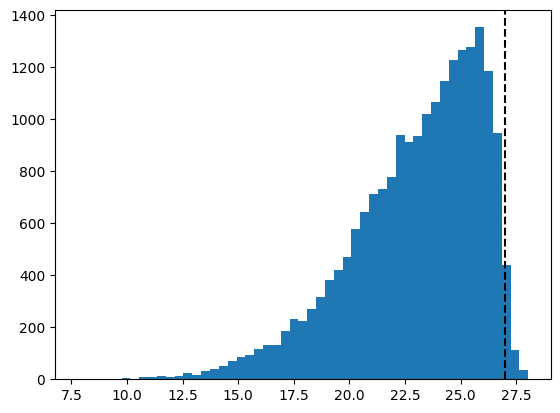

In [ ]:
#==>  ok to make a magnitude cut on 27.0 and still use this average density
plt.hist(table["i_ab"], bins=51)
plt.axvline(27.0, color='k', linestyle='--')

# Aperture background

In [ ]:
import torch
from bliss.datasets.render_utils import add_noise
from bliss.datasets.lsst import BACKGROUND


In [ ]:
x = torch.zeros(10000, 51, 51)
noise = add_noise(x)
noise.shape

torch.Size([10000, 51, 51])

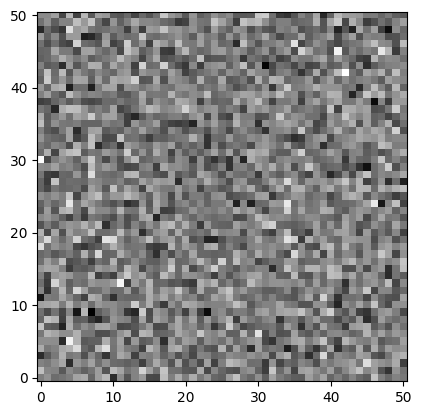

In [ ]:
plt.imshow(noise.numpy()[0], origin='lower', cmap='gray')

In [ ]:
import sep 
from tqdm import tqdm
fs = []
ferrs = [] 
for i in tqdm(range(10000)):
    f, ferr, _ = sep.sum_circle(noise.numpy()[i], [25], [25], r=5, err=BACKGROUND.sqrt().item())
    fs.append(f)
    ferrs.append(ferr)
fs = np.array(fs)
ferrs = np.array(ferrs)

100%|██████████| 10000/10000 [00:00<00:00, 32421.80it/s]


(array([  1.,   2.,   2.,   3.,  13.,   5.,  25.,  25.,  29.,  37.,  68.,
         92., 122., 161., 197., 239., 258., 315., 387., 443., 474., 498.,
        564., 599., 634., 625., 575., 544., 474., 493., 400., 332., 277.,
        235., 181., 169., 135., 104.,  77.,  67.,  37.,  26.,  20.,  15.,
         10.,   5.,   5.,   0.,   0.,   0.,   1.]),
 array([-13313.06050602, -12774.70269476, -12236.3448835 , -11697.98707224,
        -11159.62926098, -10621.27144973, -10082.91363847,  -9544.55582721,
         -9006.19801595,  -8467.84020469,  -7929.48239343,  -7391.12458217,
         -6852.76677091,  -6314.40895966,  -5776.0511484 ,  -5237.69333714,
         -4699.33552588,  -4160.97771462,  -3622.61990336,  -3084.2620921 ,
         -2545.90428085,  -2007.54646959,  -1469.18865833,   -930.83084707,
          -392.47303581,    145.88477545,    684.24258671,   1222.60039797,
          1760.95820922,   2299.31602048,   2837.67383174,   3376.031643  ,
          3914.38945426,   4452.74726552,   

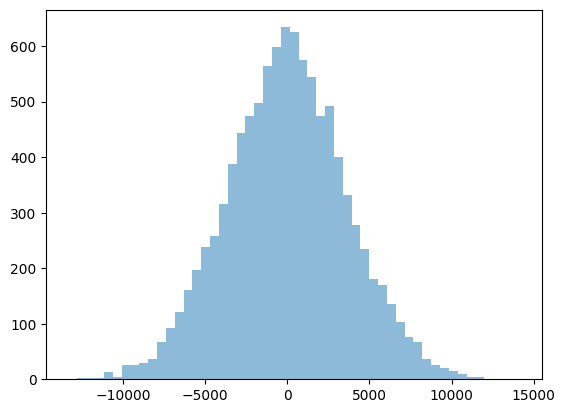

In [ ]:
plt.hist(fs, bins=51, alpha=0.5, label='fluxes')

In [ ]:
fs.std(), ferrs.mean()

(np.float64(3635.977932047668), np.float64(3776.0896291666595))